In [3]:
import pandas as pd
import joblib
import shap
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [28]:
df = pd.read_csv("data/dataset_1.csv")
print(df.columns.tolist())

['batter', 'date', 'venue', 'bowling_team', 'rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg', 'rolling_wkts_5', 'bowler_venue_avg', 'bowler_career_avg', 'bowler_vs_team_avg', 'next_match_runs', 'next_match_wicket']


In [29]:
#Runs
X_runs = df[
    ['rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg']
]

y_runs = df['next_match_runs']

In [30]:
#wickets
X_wickets = df[
    ['rolling_wkts_5', 'bowler_venue_avg', 'pvt_avg', 'pvp_avg',
     'bowler_career_avg', 'bowler_vs_team_avg']
]

y_wickets = df['next_match_wicket']

In [31]:
split = int(len(df) * 0.8)

# Runs
Xr_train, Xr_test = X_runs[:split], X_runs[split:]
yr_train, yr_test = y_runs[:split], y_runs[split:]

# Wickets
Xw_train, Xw_test = X_wickets[:split], X_wickets[split:]
yw_train, yw_test = y_wickets[:split], y_wickets[split:]

In [32]:
# Baseline prediction using rolling runs average
baseline_pred_runs = Xr_test['rolling_avg_5']

baseline_rmse_runs = np.sqrt(mean_squared_error(yr_test, baseline_pred_runs))
baseline_mae_runs  = mean_absolute_error(yr_test, baseline_pred_runs)
baseline_r2_runs   = r2_score(yr_test, baseline_pred_runs)

print("Baseline RMSE (Runs):", baseline_rmse_runs)
print("Baseline MAE (Runs):", baseline_mae_runs)
print("Baseline R² (Runs):", baseline_r2_runs)

Baseline RMSE (Runs): 6.75311315299197
Baseline MAE (Runs): 5.45483400489684
Baseline R² (Runs): -0.12426480205602508


In [33]:
# Baseline prediction using rolling wickets average
baseline_pred_wkts = Xw_test['rolling_wkts_5']

# Metrics
baseline_rmse_wkts = np.sqrt(mean_squared_error(yw_test, baseline_pred_wkts))
baseline_mae_wkts = mean_absolute_error(yw_test, baseline_pred_wkts)
baseline_r2_wkts = r2_score(yw_test, baseline_pred_wkts)

print("Baseline MAE (Wickets):", baseline_mae_wkts)
print("Baseline RMSE (Wickets):", baseline_rmse_wkts)
print("Baseline R² (Wickets):", baseline_r2_wkts)

Baseline MAE (Wickets): 0.38707904143041705
Baseline RMSE (Wickets): 0.5175711621730436
Baseline R² (Wickets): -0.07810257868523784


In [ ]:
#Random Forest-runs
rf_runs = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf_runs.fit(Xr_train, yr_train)
rf_runs_pred = rf_runs.predict(Xr_test)

In [ ]:
# XGB - runs
xgb_runs = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_runs.fit(Xr_train, yr_train)
xgb_runs_pred = xgb_runs.predict(Xr_test)

In [ ]:
# LGBM - runs
lgb_runs = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)


lgb_runs.fit(Xr_train, yr_train)
lgb_runs_pred = lgb_runs.predict(Xr_test)

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 5
[LightGBM] [Info] Start training from score 7.053214


In [37]:
#RUNS - model evaluation
def evaluate(yr_true, yr_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yr_true, yr_pred)))
    print("MAE:", mean_absolute_error(yr_true, yr_pred))
    print("R2:", r2_score(yr_true, yr_pred))


evaluate(yr_test, rf_runs_pred, "Random Forest")
evaluate(yr_test, xgb_runs_pred, "XGBoost")
evaluate(yr_test, lgb_runs_pred, "LightGBM")


 Random Forest
RMSE: 6.371714006260632
MAE: 5.313862986004857
R2: -0.0008594853780150569

 XGBoost
RMSE: 6.3943239996237216
MAE: 5.3257026749456085
R2: -0.007975177168060954

 LightGBM
RMSE: 6.417618555784309
MAE: 5.337827594332331
R2: -0.015332672304552819


In [38]:
#LightGBM - wickets
lgbw = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)

lgbw.fit(Xw_train, yw_train)

# align features
Xw_test = Xw_test[Xw_train.columns]

lgbw_pred = lgbw.predict(Xw_test)

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 6
[LightGBM] [Info] Start training from score 0.249746


In [39]:
#XGBoost - Wickets
xgbw = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgbw.fit(Xw_train, yw_train)
xgbw_pred = xgbw.predict(Xw_test)

In [40]:
# Train the Random Forest model for wickets
rfw = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rfw.fit(Xw_train, yw_train)

# Predict on test data
rfw_pred = rfw.predict(Xw_test)

In [41]:
#WICKETS - model evaluation
def evaluate(yw_true, yw_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yw_true, yw_pred)))
    print("MAE:", mean_absolute_error(yw_true, yw_pred))
    print("R2:", r2_score(yw_true, yw_pred))

evaluate(yw_test, rfw_pred, "Random Forest")
evaluate(yw_test, xgbw_pred, "XGBoost")
evaluate(yw_test, lgbw_pred, "LightGBM")


 Random Forest
RMSE: 0.4987995369735729
MAE: 0.3868122650861054
R2: -0.001318009038072443

 XGBoost
RMSE: 0.5006074196041991
MAE: 0.38669008016586304
R2: -0.008589625358581543

 LightGBM
RMSE: 0.5020478139924787
MAE: 0.38630512690493674
R2: -0.01440201843718536


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

grid_rf.fit(Xr_train, yr_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF RMSE:", -grid_rf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END max_depth=5, min_samples_leaf

In [43]:
print("Best RF Params:", grid_rf.best_params_)
print("Best RF RMSE:", -grid_rf.best_score_)

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best RF RMSE: 6.535898850687256


In [44]:
paramw_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gridw_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

gridw_rf.fit(Xw_train, yw_train)

print("Best RF Params:", gridw_rf.best_params_)
print("Best RF RMSE:", -gridw_rf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.9s
[CV] END max_depth=5, min_samples_leaf

In [45]:
print("Best RF Params:", gridw_rf.best_params_)
print("Best RF RMSE:", -gridw_rf.best_score_)

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF RMSE: 0.5035405282161042


In [46]:
rf_runs.fit(Xr_train, yr_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
rfw.fit(Xw_train, yw_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


ExactExplainer explainer: 10574it [14:17, 12.17it/s]                           


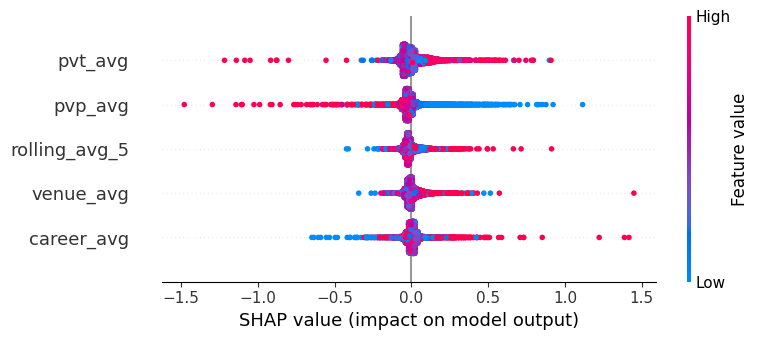

In [48]:
import shap

explainer = shap.Explainer(rf_runs.predict, Xr_train)
shap_values = explainer(Xr_test)

shap.summary_plot(shap_values, Xr_test)

ExactExplainer explainer: 10574it [23:17,  7.50it/s]                             


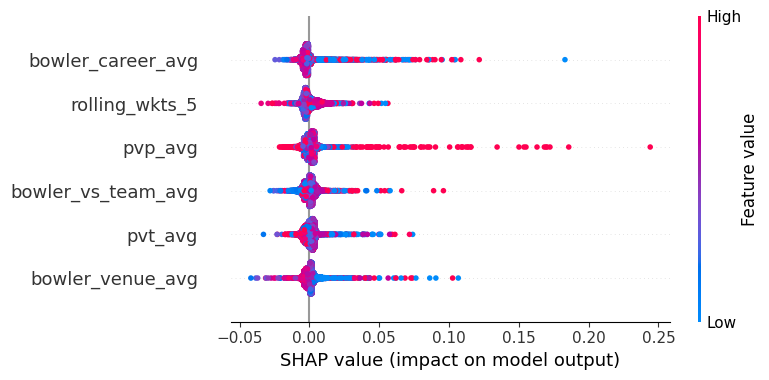

In [49]:
explainer = shap.Explainer(rfw.predict, Xw_train)
shap_values = explainer(Xw_test)

shap.summary_plot(shap_values, Xw_test)

In [50]:
joblib.dump(rf_runs, "rf_model.joblib")
print("rf_model.joblib saved for runs!")

rf_model.joblib saved for runs!


In [51]:
joblib.dump(rfw, "rfw_model.joblib")
print("rfw_model.joblib saved for wickets!")

rfw_model.joblib saved for wickets!
